### Classification

### This notebook trains a random forest classifier and validates the results.

In [2]:
import pandas as pd
import numpy as np
import pickle as pkl
from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix, precision_score, recall_score
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
# Create prediction dataframe
df = pd.read_pickle('data/final_data.pkl')
df.columns

Index(['title', 'description', 'category', 'fnd_raised', 'days_left',
       'story_txt', 'images', 'videos', 'campaign_count', 'currency',
       'fnd_perc', 'fnd_goal', 'fnd_success', 'supercategory', 'country',
       'city', 'geo_col', 'city_geo', 'country_geo', 'state', 'lng', 'lat',
       'clusters_db', 'urban', 'color', 'geometry', 'VC', 'GDP', 'VC_per_GDP',
       'title_clean', 'description_clean', 'story_txt_clean', 'title_pol',
       'title_sub', 'description_pol', 'description_sub', 'story_txt_pol',
       'story_txt_sub', 'title_len', 'description_len', 'story_txt_len'],
      dtype='object')

During EDA a lot of supporting columns were created. The following cell filters the columns down so that the data contains only those that are relevant for prediction.

In [21]:
# Only keep relevant columns
y = np.ravel(df[['fnd_success']])

X = df[['fnd_goal', 'currency', 'campaign_count', 'images', 'videos', 'supercategory', 'category',  # campaign features indigogo
        'urban', 'city', 'state', 'lng', 'lat', 'VC', 'GDP', 'VC_per_GDP',    #  geographic features
        'title_pol', 'title_sub', 'title_len', 'description_pol', 'description_sub', 'description_len', # text features
        'story_txt_pol', 'story_txt_sub', 'story_txt_len']].copy() 

Because the random forest is good at forming complex decision boundaries, categorical data does not have to be one-hot encoded. Instead, it is encoded by representing each category as a number, and a forest or tree that is deep enough can then learn the decision boundary as relevant.

In [22]:
# Preprocessing
# X = pd.get_dummies(X) #  one hot encoding
le = LabelEncoder()
X['category'] = le.fit_transform(X['category'])
X['supercategory'] = le.fit_transform(X['supercategory'])
X['currency'] = le.fit_transform(X['currency'])
X['city'] = le.fit_transform(X['city'])
X['state'] = le.fit_transform(X['state'])
X = X.fillna(X.median()) # impute missing values with median

A correlation matrix is used to gain a first look at the variables and how they might be correlated with the target.

C:\Users\stefan\AppData\Local\Temp/ipykernel_20888/3808980223.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


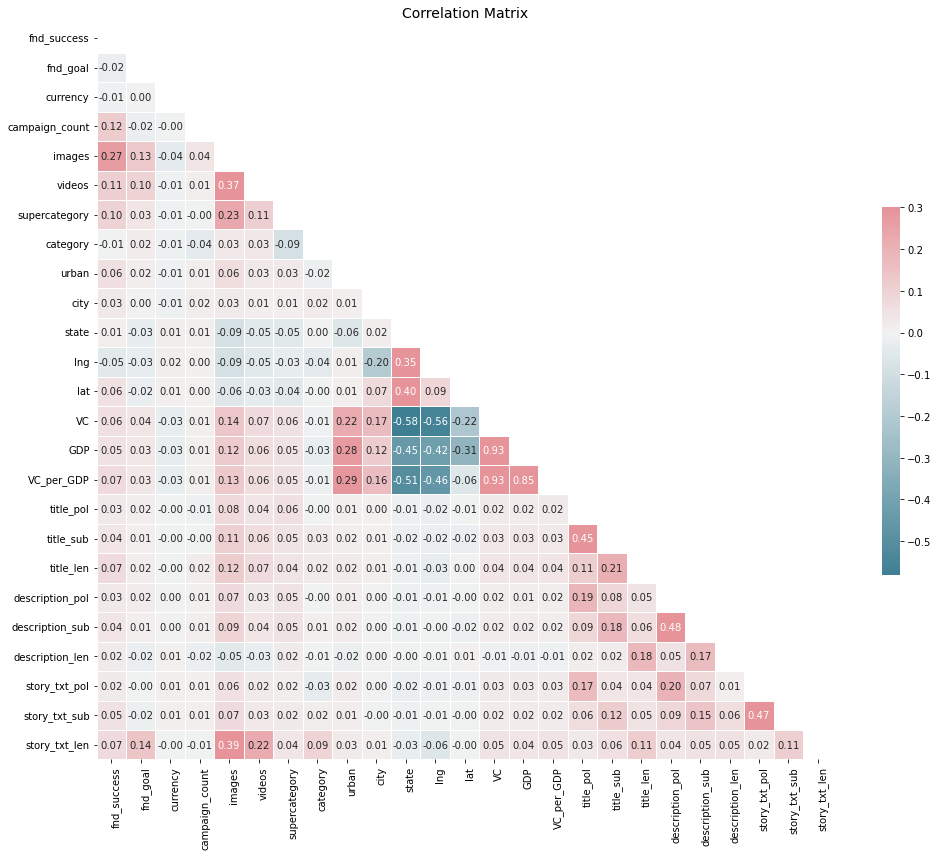

In [23]:
corr_df = X
corr_df.insert(0, 'fnd_success', y)
corr = corr_df.corr()

# Generate a mask for the lower triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot as heatmap
f, ax = plt.subplots(figsize=(15, 12))
cmap = sns.diverging_palette(220, 10, as_cmap=True) # Generate a custom diverging colormap
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
plt.title('Correlation Matrix', fontsize=14)
plt.tight_layout()
plt.show()

A train test split is applied that splits the data into 80% training and 20% testing.

In [16]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

As 79% of all campaigns in the test data are negative. 79% is the baseline accuracy the model hopefully improves on, as 79% could be achieved with a model that only predicts failure.

In [38]:
1- y_test.sum()/len(y_test)

0.7893703649847317

Parallelized bayesian optimization with 30 iterations is applied. The benefit is that the hyperparameters  can be searched by only specifying the outer limits of each parameter, and that the number of iterations and thus runtime can be specified separately  and does not depend on the number of hyperparameter values that are tested like for grid-search. 

In [17]:
# Hyperparameter tuning Bayes Search
opt = BayesSearchCV(
    estimator=RandomForestClassifier(bootstrap=True, n_jobs=-1),
    search_spaces={
        'n_estimators': (100, 2000),
        'max_depth': (100, 1000),
        'max_features': (0.2, 1.0),
        'max_samples': (0.2, 1.0)
    }, 
    n_iter=30,
    cv=3,
    verbose=1
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

In [19]:
# save random forest
with open('models/rf_model_classifier_20122021.pkl', 'wb') as f:
    pkl.dump(opt.best_estimator_, f)

The best estimator uses all features, the deepest tree, and the most number of learners possible.

In [20]:
# Shows parameters of best estimator
rf = opt.best_estimator_
print(opt.best_params_)

OrderedDict([('max_depth', 1000), ('max_features', 1.0), ('max_samples', 0.7546307857360042), ('n_estimators', 2000)])


The best estimator is tested against the unseen test set to get the final evaluation metrics. The final model has an accuracy of 83, which constitutes a 4% improvement over the baseline 79%.

In [41]:
y_pred = rf.predict(X_test)
# Evaluate model
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.7018229166666666
0.372109078356921
              precision    recall  f1-score   support

           0       0.85      0.96      0.90     10857
           1       0.70      0.37      0.49      2897

    accuracy                           0.83     13754
   macro avg       0.78      0.66      0.69     13754
weighted avg       0.82      0.83      0.81     13754



The model has relatively high precision of 70% but seemingly at the cost of low recall of 37%. The low sensitivity of the model is showcased by the confusion matrix below.

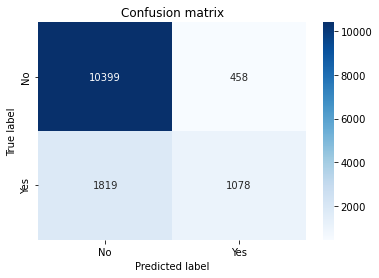

In [34]:
# plot confusion matrix
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_pred),
    index = [i for i in ["No", "Yes"]],
    columns = [i for i in ["No", "Yes"]]
), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Finally, a plot of the importance of the model features sheds light on the amount of information in each parameter that is useful for prediction.

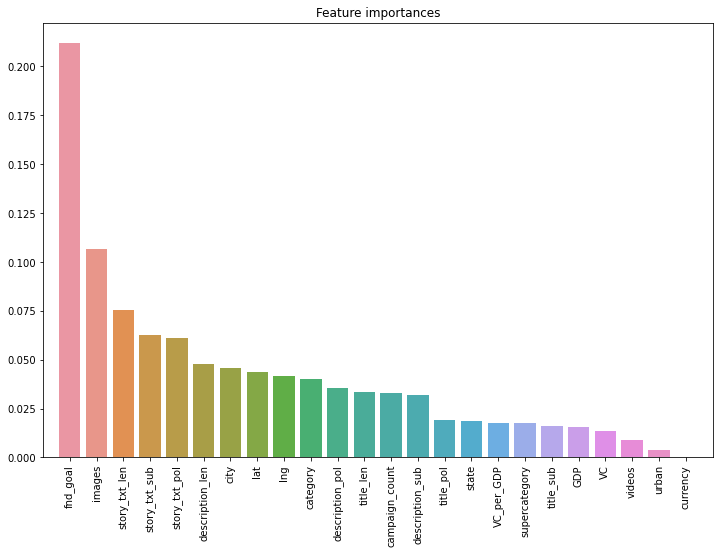

In [23]:
# Plot feature importance
importances = rf.feature_importances_
#std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,8))
plt.title("Feature importances")
sns.barplot(x=X.columns[indices], y=importances[indices]) # , yerr=std[indices]
plt.xticks(rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()